In [34]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder
import matplotlib.pyplot as plt
from odbm.vis import rxn_plot


In [35]:
model_species = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl')
model_rxns = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Reaction', engine = 'openpyxl')

In [36]:
expression_limit = 0.05 
N_enzymes = 3
expression_fudge = 1/10
enzymeInit = expression_limit/N_enzymes*expression_fudge

solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

# this kind of works
model_species.loc[model_species['Label'] == 'ATP','Label'] = '$ATP'
model_species.loc[model_species['Label'] == 'ATP','StartingConc'] = solubilities['ATP']

serine_mw = 105.09
malate_mw = 134.0874

In [37]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
r  = te.loada(model)

sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))

In [38]:
results_id = np.empty((len(sdaV), len(pcxV), len(mdhV)), dtype=int)
results = []

count = 0
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            r['['+sda+']'] = enzymeInit
            r['['+pcx+']'] = enzymeInit
            r['['+mdh+']'] = enzymeInit
            results_id[i,j,k] = count
            results.append(r.simulate(0,1200,1000))
            r.reset()
            count += 1

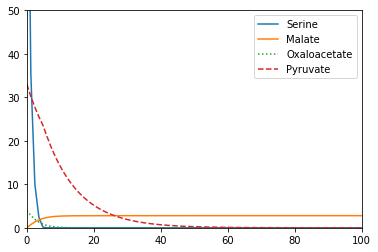

In [39]:
df = pd.DataFrame(results[0], columns = results[0].colnames)
df.round(2)
plt.plot(df['time'],df['[SERINE]'],  label = 'Serine')
plt.plot(df['time'],df['[MALICACID]'], label = 'Malate')
plt.plot(df['time'],df['[OXALOACETICACID]'],  linestyle = 'dotted', label = 'Oxaloacetate')
plt.plot(df['time'],df['[PYRUVICACID]'], linestyle = 'dashed', label = 'Pyruvate')

plt.xlim(0, 100)
plt.ylim(0,50)
plt.legend()

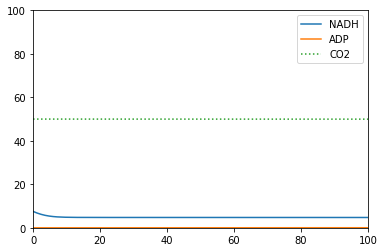

In [40]:
df = pd.DataFrame(results[0], columns = results[0].colnames)
df.round(2)
plt.plot(df['time'],df['[NADH]'],  label = 'NADH')
plt.plot(df['time'],df['[ADP]'], label = 'ADP')
plt.plot(df['time'],df['[CO2]'],  linestyle = 'dotted', label = 'CO2')

plt.xlim(0, 100)
plt.ylim(0,100)
plt.legend()

In [41]:

# for sim in results[16:24]:
#     plt.figure()
#     for species in sim[1:]:
#         plt.plot(sim[0],species)
#     # plt.legend(labels = ['Serine','Pyruvate','Oxaloacetate', 'Malate'])



(<Figure size 1152x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029A0F164E08>,
       dtype=object))

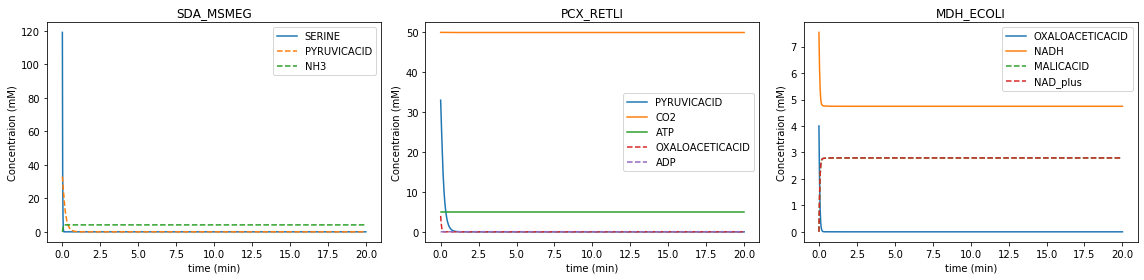

In [42]:
variants = (0,0,0) #define combination of variants to plot
v_labels = [v[k] for v,k in zip([sdaV, pcxV, mdhV], variants)] #get variant names
run = int(results_id[variants]) #return simulation run  # in which that combination was tested
rxn_idx = [int(variants[0]),int(variants[1]+4), int(variants[2]+8)] #brute force method of getting reaction index for each variant
rxn_plot(myModel, results[run], rxn_idx, figsize=(16,4), titles = v_labels)

In [43]:
(results[0]['time']/60)[-1]

20.0

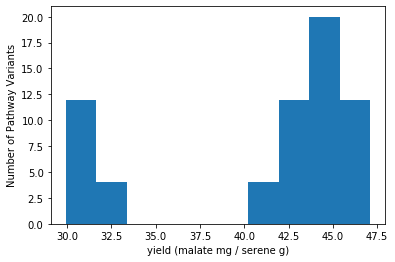

In [44]:
plt.hist([((r['[MALICACID]'][-1]*malate_mw)/(r['[SERINE]'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

In [45]:
#dummy test of different enzyme ratios 
#testing just one combination of enzyme variants

ratios = [1,5,10]
results_id = np.empty((len(ratios), len(ratios), len(ratios)), dtype=int)
results = []

for i in ratios:
    for j in ratios:
        for k in ratios:
            r['['+sdaV[0]+']'] = enzymeInit*(i/sum(ratios))
            r['['+pcxV[0]+']'] = enzymeInit*(j/sum(ratios))
            r['['+mdhV[0]+']'] = enzymeInit*(k/sum(ratios))

            results.append(r.simulate(0,1200,1000))
            r.reset()


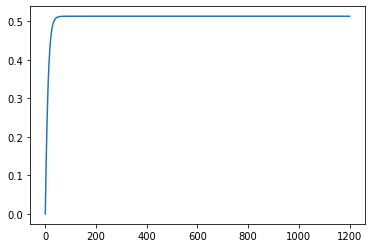

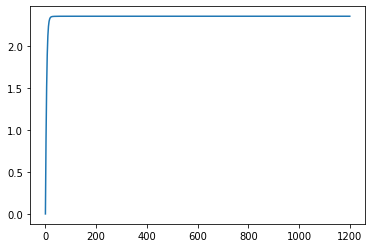

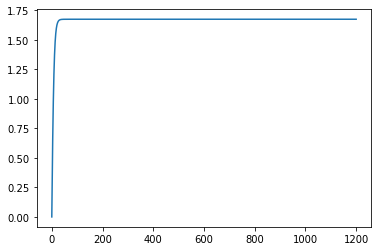

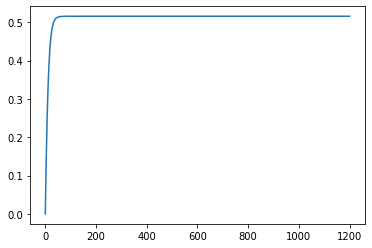

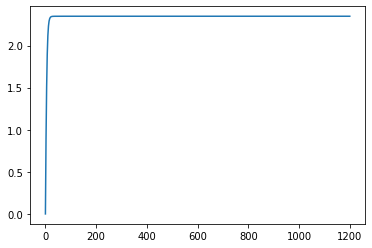

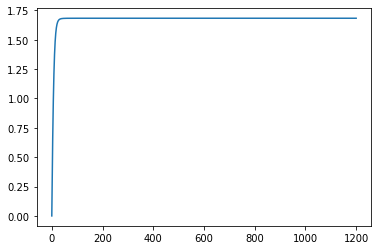

In [46]:
'''
species = ['[SERINE]','[PYRUVICACID]','[OXALOACETICACID]', '[MALICACID]']
sample = [0, 5, 10, 15, 20, 25]
for s in sample:
    sim = results[s]
    plt.figure()
    for sp in species:
        plt.plot(sim['time'],sim[sp])
        plt.legend(labels = ['Serine','Pyruvate','Oxaloacetate', 'Malate'])
'''

sample = [0, 5, 10, 15, 20, 25]
for s in sample:
    sim = results[s]
    plt.figure()
    plt.plot(sim['time'],sim['[MALICACID]'])




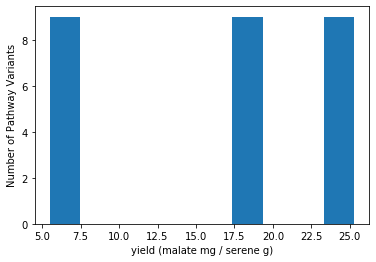

In [47]:
plt.hist([((r['[MALICACID]'][-1]*malate_mw)/(r['[SERINE]'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

In [33]:
myModel.species


,Label,Type,StartingConc,Mechanisms
0,Serine,Metabolite,119.04760,NaN
1,CO2,Metabolite,50.00000,NaN
2,Pyruvic acid,Metabolite,33.00000,NaN
3,Oxaloacetic acid,Metabolite,4.00000,NaN
4,$ATP,Cofactor,4.93095,NaN
5,AMP,Cofactor,0.00000,NaN
6,ADP,Cofactor,0.00000,NaN
7,NADPH,Cofactor,10.00000,NaN
8,NADP+,Cofactor,0.00000,NaN
9,NADH,Cofactor,7.53695,NaN
